# Preprocessing Dual Energy Carbonate CT Data

Before running the Monte Carlo inversion, we need to perform some pre-configurations. 
In this tutorial, we will process this data directly within the Jupyter Notebook, 
in a parallel MPI environment using [ipyparallel](https://ipyparallel.readthedocs.io/).

Let's first create a cluster with a set of 5 MPI engines:

In [1]:
import ipyparallel as ipp

# Create an MPI cluster with 5 engines
cluster = ipp.Cluster(engines="mpi", n=5)

# Start and connect to the cluster
rc = cluster.start_and_connect_sync()

# Enable IPython magics for parallel processing
rc[:].activate()

Starting 5 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

This will enable the `%%px` 
[cell magic](https://ipyparallel.readthedocs.io/en/latest/examples/Parallel%20Magics.html#px-cell-magic), 
which allows RockVerse to perform parallel processing interactively within this Jupyter notebook.

Let's create the dual energy group and import the 
[raw images we downloaded from the Digital Rocks Portal](../sample_data/import_C04B21_dualenergy.ipynb):

In [2]:
%%px --block --group-outputs=type

import matplotlib.pyplot as plt
from IPython.display import display
import rockverse as rv

# Create the Dual Energy CT group
dectgroup = rv.dualenergyct.create_group(
    store='/path/to/dual_energy_ct/C04B21',
    overwrite=True)

# Copy the low energy CT image
dectgroup.copy_image(
    image=rv.open('/path/to/imported/dual_energy_carbonate/C04B21Raw100keV'),
    path='lowECT',
    overwrite=True)

# Copy the high energy CT image
dectgroup.copy_image(
    image=rv.open('/path/to/imported/dual_energy_carbonate/C04B21Raw140keV'),
    path='highECT',
    overwrite=True)

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

[2025-01-10 17:46:09] Copying array:   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:12] Copying array:   0%|          | 0/256 [00:00<?, ?chunk/s]

Now, let's take a quick look at the data using the orthogonal viewer:

[output:0]

[2025-01-10 17:46:16] Histogram Low attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:18] Histogram Low attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

[2025-01-10 17:46:22] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:23] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

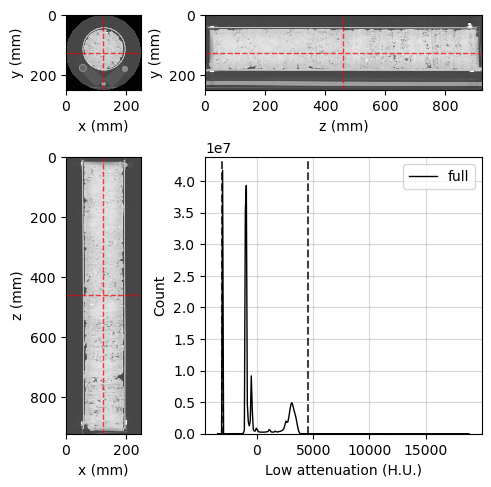

[output:0]

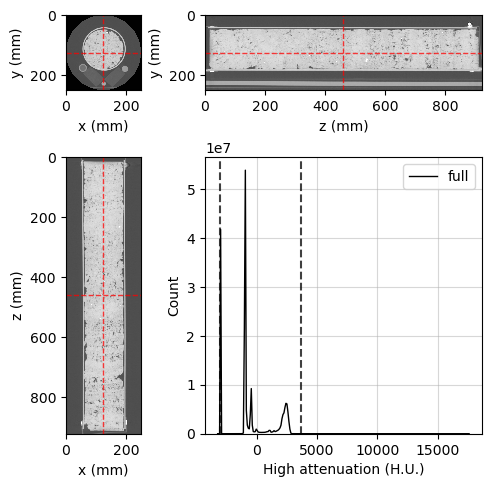

In [3]:
%%px --block --group-outputs=type

# Create orthogonal viewers for low and high energy images
lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT)

#Each process will create it's own repeated image, let's close all but rank zero:
if rv.config['MPI']['mpi_rank'] != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)

## Building the segmentation image


A segmentation image is needed to inform RockVerse about the spatial location of the standard materials.
While the segmentation image is not available in the Digital Rocks Portal, the rock sample and the standard 
materials are fairly aligned with the image's z-axis. Let's quickly build a segmentation image with 
RockVerse's cylindrical regions. 
A little trial and error is all it takes in this case:

### Air

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

[2025-01-10 17:46:29] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:30] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

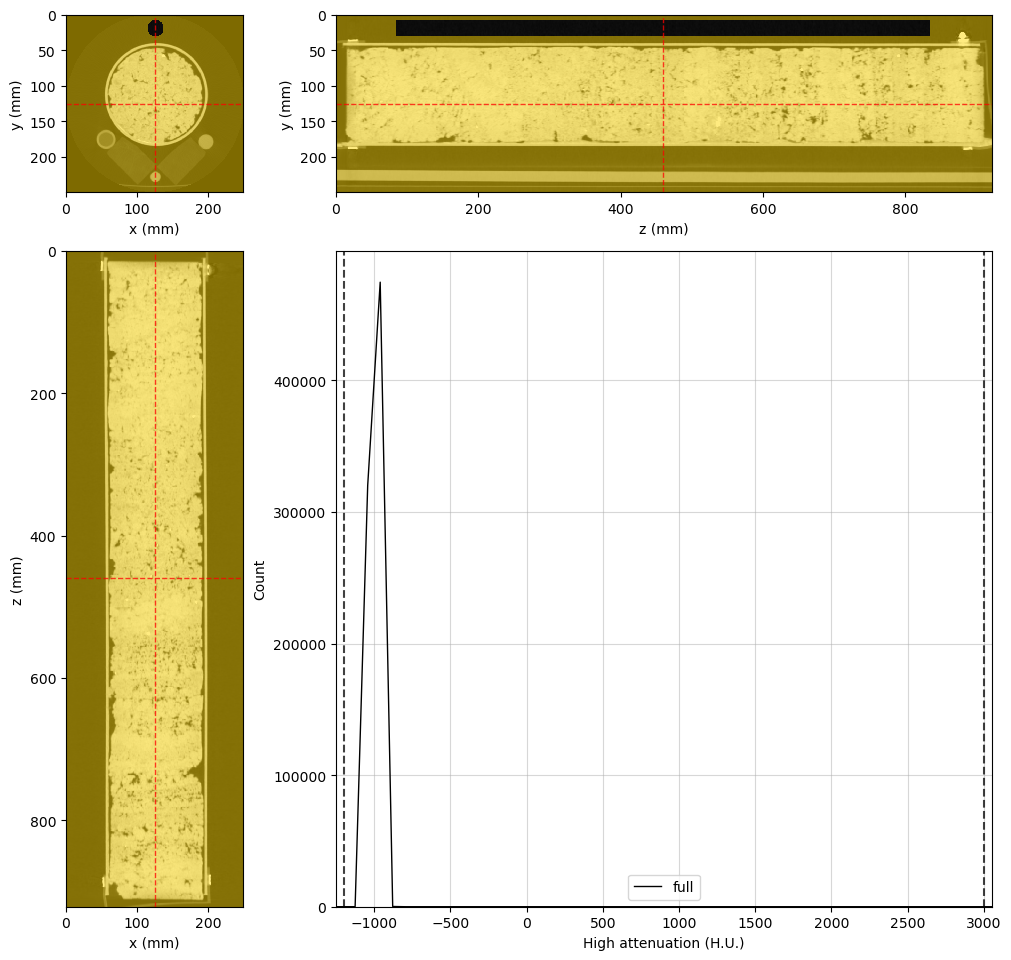

In [4]:
%%px --block --group-outputs=type

#Adjusting viewer properties will help us in this task
highE_viewer.figure.set_size_inches(10, 10)
highE_viewer.update_image_dict(clim=(-1200, 3000))
highE_viewer.mask_color = 'gold'
highE_viewer.mask_alpha = 0.5

#This is the final cylindrical region for probing air attenuation
air_region = rv.region.Cylinder(p=(126, 20, 461), v=(0, 0, 1), r=10, l=750)

# Set the region in the viewer and visualize the result
highE_viewer.region = air_region

#Changing region rebuilds the histogram. Let's set the scale again
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

# Only display the figure for rank 0
if rv.config['MPI']['mpi_rank'] == 0:
    display(highE_viewer.figure)

### Water

[output:0]

[2025-01-10 17:46:33] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:33] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

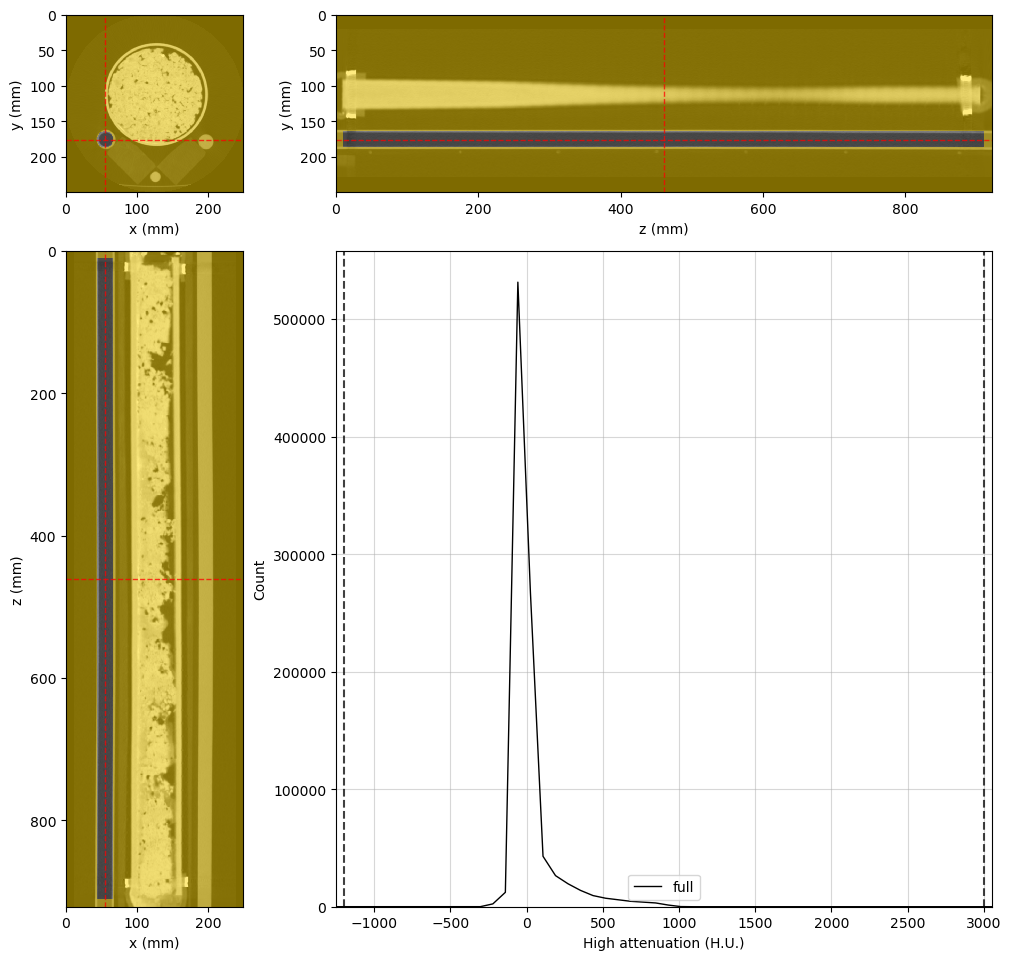

In [5]:
%%px --block --group-outputs=type

#Final water region
water_region = rv.region.Cylinder(p=(55, 176.2, 461), v=(0, 0, 1), r=10, l=900)

#Adjust the viewer and display for rank 0
highE_viewer.region = water_region
highE_viewer.ref_point = water_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config['MPI']['mpi_rank'] == 0:
    display(highE_viewer.figure)

### Teflon

[output:0]

[2025-01-10 17:46:37] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:38] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

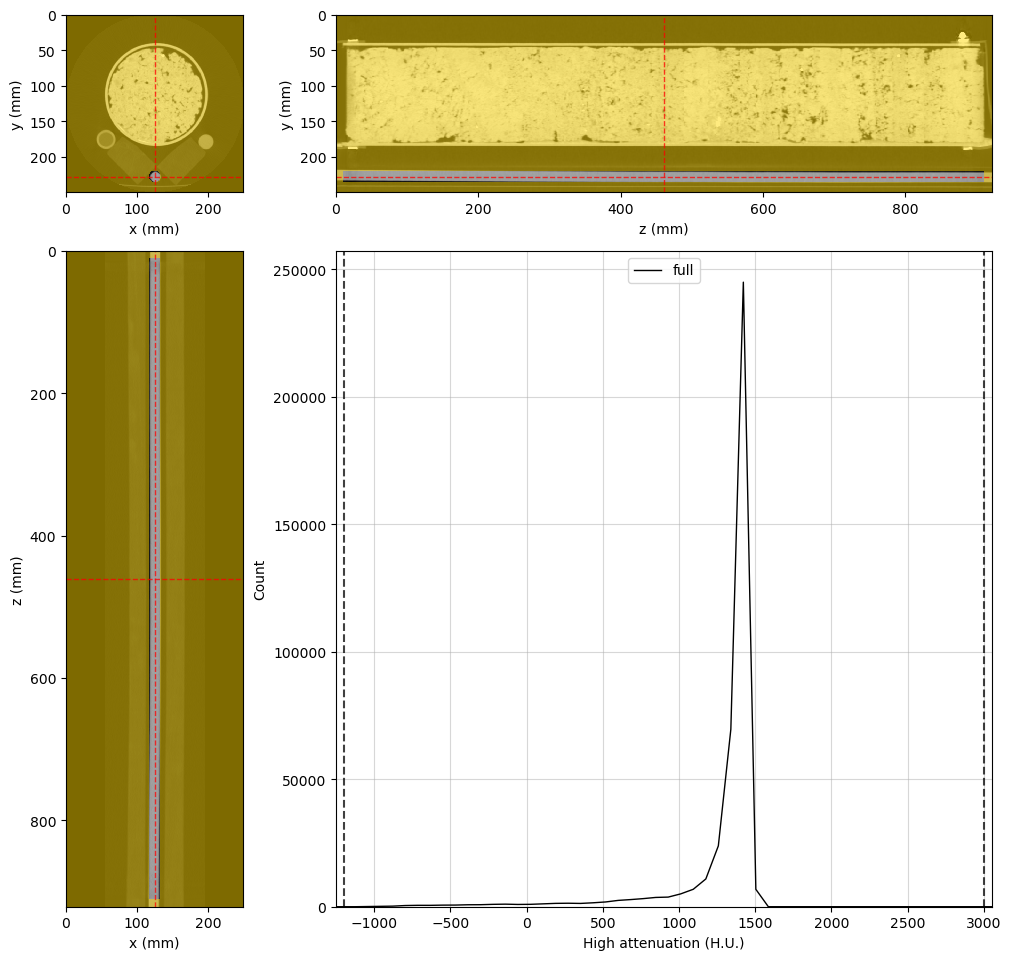

In [6]:
%%px --block --group-outputs=type

#Final teflon region
teflon_region = rv.region.Cylinder(p=(124.7, 228, 461), v=(0, 0, 1), r=6.5, l=900)

#Adjust the viewer and display for rank 0
highE_viewer.region = teflon_region
highE_viewer.ref_point = teflon_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config['MPI']['mpi_rank'] == 0:
    display(highE_viewer.figure)

### Silica

[output:0]

[2025-01-10 17:46:42] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:42] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

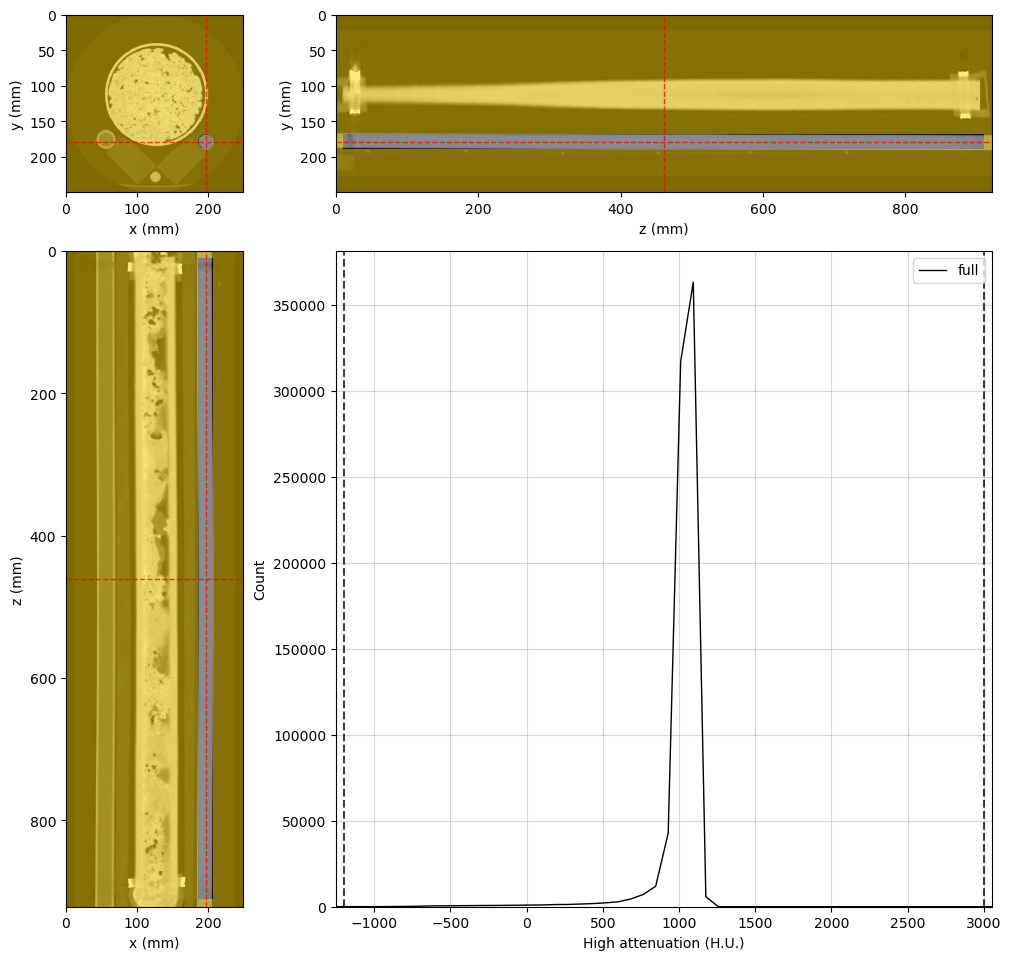

In [7]:
%%px --block --group-outputs=type

#Final silica region
silica_region = rv.region.Cylinder(p=(196, 179, 461), v=(0, 0, 1), r=9, l=900)

#Adjust the viewer and display for rank 0
highE_viewer.region = silica_region
highE_viewer.ref_point = silica_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config['MPI']['mpi_rank'] == 0:
    display(highE_viewer.figure)

### Rock sample

[output:0]

[2025-01-10 17:46:46] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:47] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

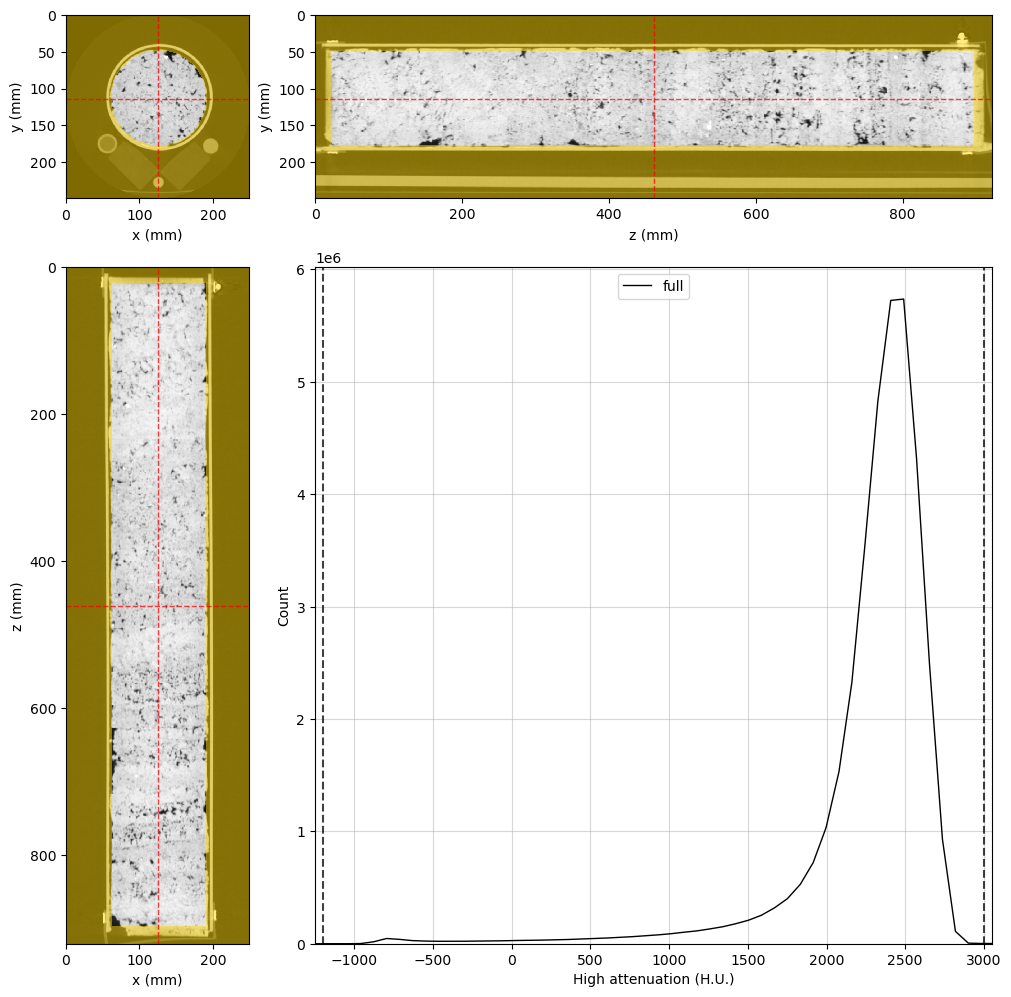

In [8]:
%%px --block --group-outputs=type

#Final rock region
rock_region = rv.region.Cylinder(p=(126, 114, 461), v=(0, 0, 1), r=63, l=875)

#Adjust the viewer and display for rank 0
highE_viewer.region = rock_region
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config['MPI']['mpi_rank'] == 0:
    display(highE_viewer.figure)

### Combined segmentation image

Now, we can use these regions to create the final segmentation image:

[output:0]

[2025-01-10 17:46:51] (segmentation) Set:   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:52] (segmentation) Set:   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:52] (segmentation) Set:   0%|          | 0/256 [00:00<?, ?chunk/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

[2025-01-10 17:46:53] (segmentation) Set:   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:54] (segmentation) Set:   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:55] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:55] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:58] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:46:58] Histogram High attenuation (reading segmentation):   0%|          | 0/256 [00:00<?, ?chu…

[output:0]

[2025-01-10 17:46:59] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

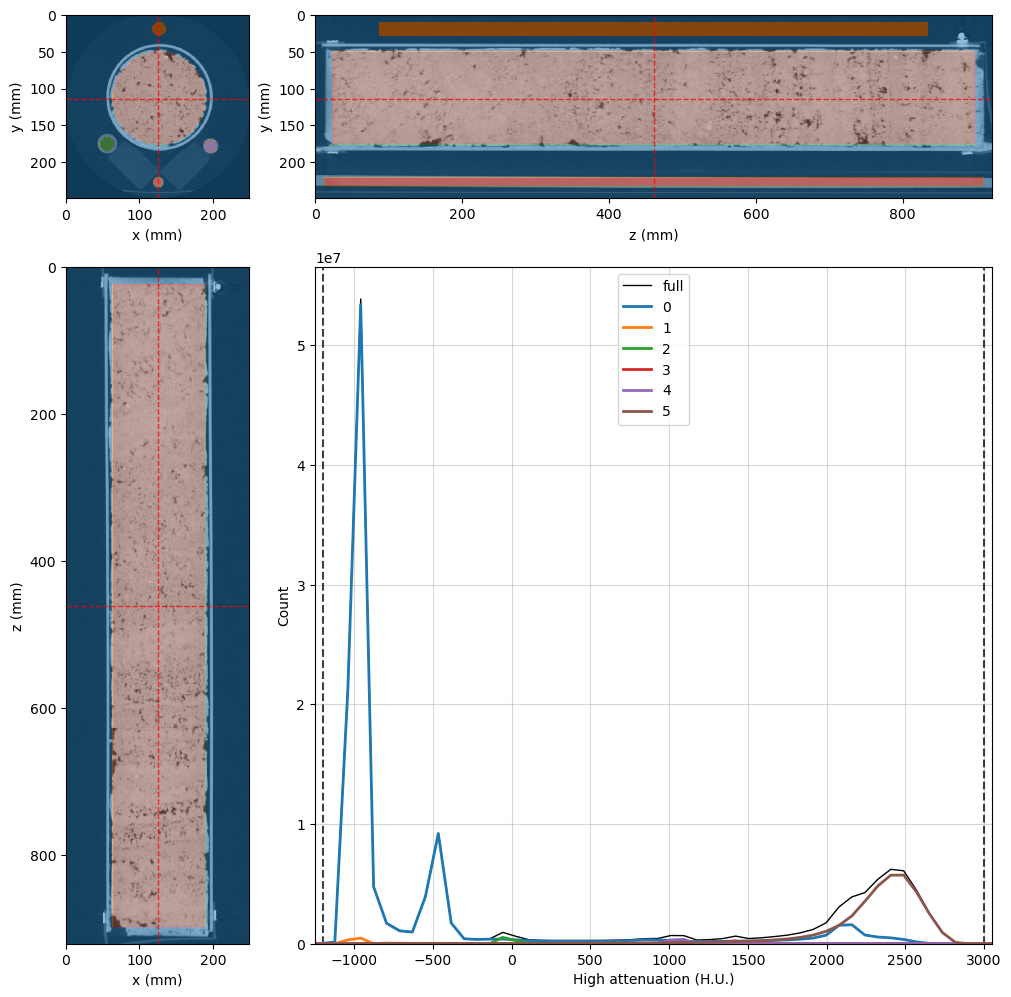

In [9]:
%%px --block --group-outputs=type

# Create the segmentation voxel image inside the dual energy group
dectgroup.create_segmentation(fill_value=0, overwrite=True)

# Use the VoxelImage math method to assign each region
dectgroup.segmentation.math(value=1, op='set', region=air_region)    #Air
dectgroup.segmentation.math(value=2, op='set', region=water_region)  #Water
dectgroup.segmentation.math(value=3, op='set', region=teflon_region) #Teflon
dectgroup.segmentation.math(value=4, op='set', region=silica_region) #Silica
dectgroup.segmentation.math(value=5, op='set', region=rock_region)   #Rock sample

#Adjust the viewer and display for rank 0
highE_viewer.region = None
highE_viewer.segmentation = dectgroup.segmentation
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config['MPI']['mpi_rank'] == 0:
    display(highE_viewer.figure)

## Mask Image

It is a good practice to save time in the Monte Carlo inversion by masking out voxels for which we are not interested 
in the results. While we cannot assign regions to DualEnergyCT groups, we can create an arbitrary mask voxel image to 
inform RockVerse which voxels should be ignored. In our case, phase 0 in our segmentation image represents the regions 
we want to exclude from our inversion:

[output:0]

[2025-01-10 17:47:04] (mask) Set:   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:47:05] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

[2025-01-10 17:47:06] Histogram High attenuation (reading segmentation):   0%|          | 0/256 [00:00<?, ?chu…

[output:0]

[2025-01-10 17:47:07] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

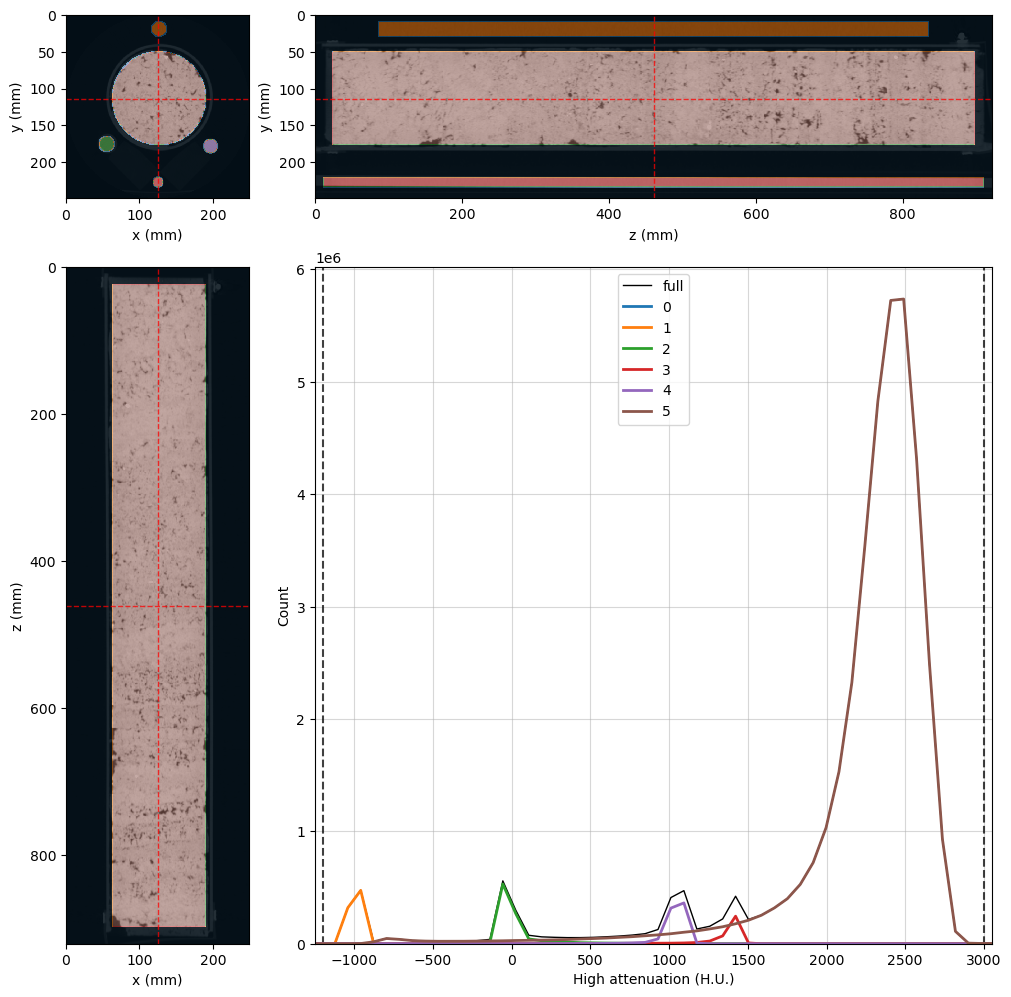

In [10]:
%%px --block --group-outputs=type

#Create the empty mask
dectgroup.create_mask(fill_value=False, overwrite=True)

#Use VoxelImage math method to set mask to True where segmentation is 0
dectgroup.mask.math(value=True,
                    op='set',
                    segmentation=dectgroup.segmentation,
                    phases=(0,))

#Adjust the viewer and display for rank 0
highE_viewer.mask = dectgroup.mask
highE_viewer.mask_color = 'k'
highE_viewer.mask_alpha = 0.75
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config['MPI']['mpi_rank'] == 0:
    display(highE_viewer.figure)


The black voxels in the image above will be ignored during the Monte Carlo inversion.

Now that we are satisfied with the segmentation and mask, we need to calculate a more detailed 
histogram, as the histogram counts will serve as the basis for calculating the probability
density functions for the X-ray attenuation values in the standard materials. 
Once again, some testing led to the final choice of $2^{10}$ bins.

Let's update our viewer one last time:

[output:0]

[2025-01-10 17:47:13] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:47:14] Histogram High attenuation (reading segmentation):   0%|          | 0/256 [00:00<?, ?chu…

[output:0]

[2025-01-10 17:47:14] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

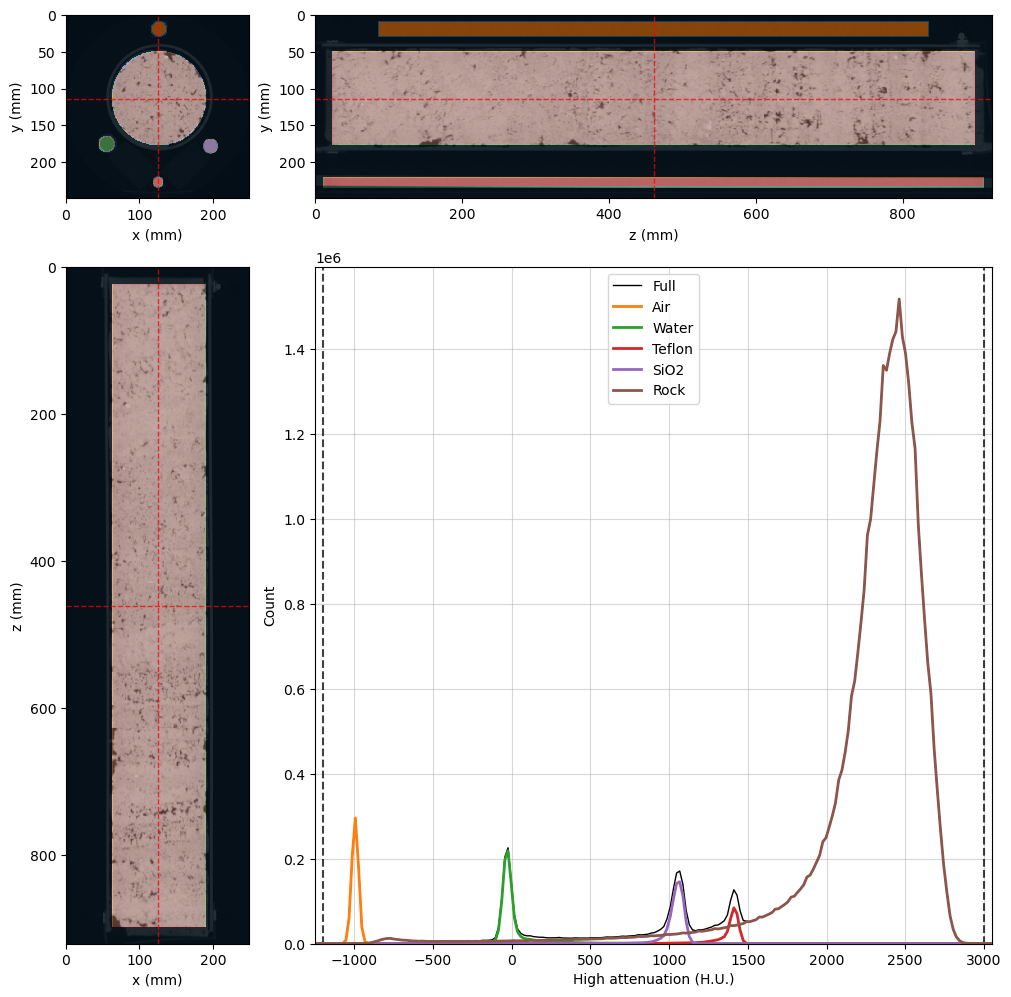

In [11]:
%%px --block --group-outputs=type

#Set the number of histogram bins
highE_viewer.histogram_bins = 2**10

#Fix the scale, as the histogram was rebuilt
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

#Write the material names in the histogram legend
highE_viewer.ax_histogram.legend(
    [
        highE_viewer.histogram_lines['full'],
        highE_viewer.histogram_lines['1'],
        highE_viewer.histogram_lines['2'],
        highE_viewer.histogram_lines['3'],
        highE_viewer.histogram_lines['4'],
        highE_viewer.histogram_lines['5'],
    ], [
        'Full',
        'Air',
        'Water',
        'Teflon',
        'SiO2',
        'Rock'
    ]
)

#Show figire for rank 0
if rv.config['MPI']['mpi_rank'] == 0:
    display(highE_viewer.figure)

## Run the preprocessing step

Now we are ready to set the processing parameters and run the pre-processing step.
Our little cluster with 5 MPI processes is still enough for this task.

In [12]:
%%px --block --group-outputs=type

# Set the number of histogram bins as previously decided
dectgroup.histogram_bins = 2**10

# Fill in the calibration materials dictionaries

dectgroup.calibration_material0['description'] = 'Air'
dectgroup.calibration_material0['segmentation_phase'] = 1
dectgroup.calibration_material0['lowE_gaussian_center_bounds'] = [-1050, -950]
dectgroup.calibration_material0['highE_gaussian_center_bounds'] = [-1050, -950]

dectgroup.calibration_material1['description'] = 'Water'
dectgroup.calibration_material1['segmentation_phase'] = 2
dectgroup.calibration_material1['composition'] = {'H': 2, 'O': 1}
dectgroup.calibration_material1['bulk_density'] = 1
dectgroup.calibration_material1['lowE_gaussian_center_bounds'] = [-100, 100]
dectgroup.calibration_material1['highE_gaussian_center_bounds'] = [-100, 100]

dectgroup.calibration_material2['description'] = 'SiO2'
dectgroup.calibration_material2['segmentation_phase'] = 3
dectgroup.calibration_material2['composition'] = {'Si': 1, 'O': 2}
dectgroup.calibration_material2['bulk_density'] = 2.2
dectgroup.calibration_material2['lowE_gaussian_center_bounds'] = [1550, 1700]
dectgroup.calibration_material2['highE_gaussian_center_bounds'] = [1300, 1500]

dectgroup.calibration_material3['description'] = 'Teflon'
dectgroup.calibration_material3['segmentation_phase'] = 4
dectgroup.calibration_material3['composition'] = {'C': 2, 'F': 4}
dectgroup.calibration_material3['bulk_density'] = 2.2
dectgroup.calibration_material3['lowE_gaussian_center_bounds'] = [1000, 1200]
dectgroup.calibration_material3['highE_gaussian_center_bounds'] = [1000, 1100]

# Call the preprocess method
dectgroup.preprocess()

[output:0]

[2025-01-10 17:47:19] Hashing Low attenuation:   0%|          | 0/512 [00:00<?, ?line/s]

[output:1]

[2025-01-10 17:47:19] Hashing High attenuation:   0%|          | 0/512 [00:00<?, ?line/s]

[output:2]

[2025-01-10 17:47:19] Hashing mask:   0%|          | 0/512 [00:00<?, ?line/s]

[output:3]

[2025-01-10 17:47:19] Hashing segmentation:   0%|          | 0/512 [00:00<?, ?line/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

[2025-01-10 17:47:21] Histogram Low attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:47:22] Histogram Low attenuation (reading segmentation):   0%|          | 0/256 [00:00<?, ?chun…

[output:0]

[2025-01-10 17:47:22] Histogram Low attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:47:24] Histogram High attenuation (min/max):   0%|          | 0/256 [00:00<?, ?chunk/s]

[output:0]

[2025-01-10 17:47:24] Histogram High attenuation (reading segmentation):   0%|          | 0/256 [00:00<?, ?chu…

[output:0]

[2025-01-10 17:47:25] Histogram High attenuation (counting voxels):   0%|          | 0/256 [00:00<?, ?chunk/s]

[stdout:0] [2025-01-10 17:47:27] Gaussian coefficients for calibration histograms:
                               A_lowE      mu_lowE  sigma_lowE        A_highE     mu_highE  sigma_highE
Calibration material 0  289996.000246  -998.709782   23.171523  295984.001208  -995.363426    21.752511
Calibration material 1  182410.932712   -34.332426   34.220852  218833.963498   -28.880517    28.371563
Calibration material 2   60297.000982  1627.787462   38.406920   84530.971634  1411.262199    28.102848
Calibration material 3  119368.999974  1110.598387   48.387580  145789.001821  1054.907940    37.473448


[output:0]

[2025-01-10 17:47:27] Generating inversion coefficients:   0%|          | 0/100000 [00:00]

## Appraisal

Let's take a look at the preprocessing results. 
This time, we will work locally instead of in the ipyparallel cluster,
so we need to load the libraries and the DECT group again.


In [61]:
# Note that we are not using the %%px cell magic anymore!
# Now the process will run locally, so we nee to start over

import matplotlib.pyplot as plt
import numpy as np
import rockverse as rv

#Load the DECT group
dectgroup = rv.open(r'/path/to/dual_energy_ct/C04B21')

The results can be accessed through the following attributes:

- ``calibration_gaussian_coefficients``: histogram fitting parameters,
- ``lowEhistogram``: a Pandas DataFrame with the histogram values for the low energy image,
- ``highEhistogram``: a Pandas DataFrame with the histogram values for the high energy image.

Let's take a look at each one of them:


In [186]:
print(dectgroup.calibration_gaussian_coefficients)

                               A_lowE      mu_lowE  sigma_lowE        A_highE  \
Calibration material 0  289996.000246  -998.709782   23.171523  295984.001208   
Calibration material 1  182410.932712   -34.332426   34.220852  218833.963498   
Calibration material 2   60297.000982  1627.787462   38.406920   84530.971634   
Calibration material 3  119368.999974  1110.598387   48.387580  145789.001821   

                           mu_highE  sigma_highE  
Calibration material 0  -995.363426    21.752511  
Calibration material 1   -28.880517    28.371563  
Calibration material 2  1411.262199    28.102848  
Calibration material 3  1054.907940    37.473448  


In [187]:
print(dectgroup.lowEhistogram)

      bin_centers  full    0    1    2    3    4    5
0         -3013.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1         -2992.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2         -2971.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
3         -2949.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0
4         -2928.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
...           ...   ...  ...  ...  ...  ...  ...  ...
1018      18809.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1019      18830.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1020      18852.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1021      18873.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1022      18895.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

[1023 rows x 8 columns]


In [188]:
print(dectgroup.highEhistogram)

      bin_centers  full    0    1    2    3    4    5
0         -3014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1         -2994.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2         -2974.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
3         -2954.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
4         -2933.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0
...           ...   ...  ...  ...  ...  ...  ...  ...
1018      17555.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1019      17576.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1020      17596.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1021      17616.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1022      17636.5   0.0  0.0  0.0  0.0  0.0  0.0  0.0

[1023 rows x 8 columns]


In [189]:
print(dectgroup.lowE_inversion_coefficients)

              CT_0       CT_1         CT_2         CT_3       Z_1        Z_2  \
0      -985.170479 -37.306378  1666.372996  1122.924137  6.527659  10.766077   
1      -964.931235   5.535268  1648.049931  1113.200129  6.786124  10.900328   
2     -1012.908623 -13.513897  1611.467335  1107.138637  6.771209  10.891468   
3     -1046.961518 -19.173814  1644.411155  1080.709431  7.077239  11.115299   
4      -997.138394 -62.216043  1584.344279  1097.574787  6.338426  10.687342   
...            ...        ...          ...          ...       ...        ...   
49995  -984.605957 -48.646933  1712.478114  1130.728745  6.512674  10.759343   
49996 -1021.160551 -16.025717  1585.980803  1174.808622  6.200749  10.637237   
49997  -987.181841 -36.027791  1683.475938  1119.689917  6.600320  10.800156   
49998 -1008.123921   9.894383  1608.108562  1077.615564  7.131072  11.167076   
49999 -1002.515727 -26.023097  1647.234131  1148.366294  6.453079  10.733473   

            Z_3           A           B

In [190]:
print(dectgroup.highE_inversion_coefficients)

              CT_0       CT_1         CT_2         CT_3       Z_1        Z_2  \
0      -972.119692 -61.855281  1373.633630  1009.935635  6.196998  10.635942   
1      -995.163422  -9.659287  1437.533121  1034.317253  6.845608  10.937364   
2      -995.733691 -29.692926  1423.685461  1064.376054  6.309353  10.676320   
3     -1016.058563 -29.976892  1348.716677   996.951784  6.798889  10.908042   
4      -972.056570 -15.896895  1369.379369  1071.652142  5.978736  10.565857   
...            ...        ...          ...          ...       ...        ...   
49995  -997.485334  -9.747728  1439.923330  1032.932630  6.874736  10.956576   
49996  -975.594496  -7.938519  1442.023101  1098.018626  6.180434  10.630262   
49997  -991.763846 -20.630767  1418.271162  1052.415116  6.480210  10.745076   
49998  -994.250103  11.222071  1430.763494  1075.827878  6.670365  10.835499   
49999 -1035.331221 -76.033176  1392.428911  1022.440473  6.300023  10.672835   

            Z_3           A           B

Let's write some code to retrieve these parameters and display some plots:

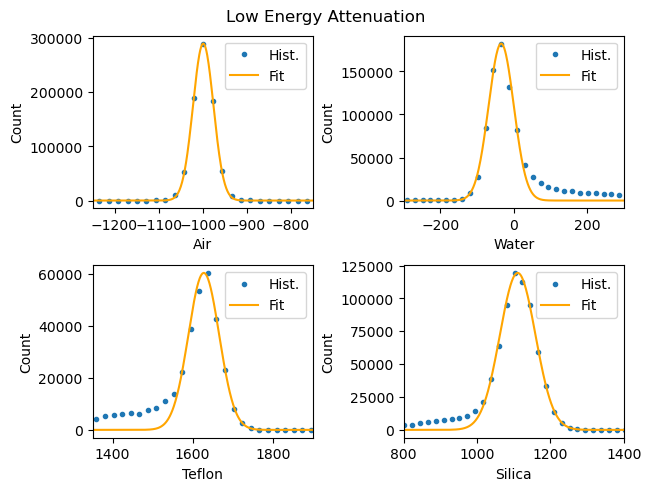

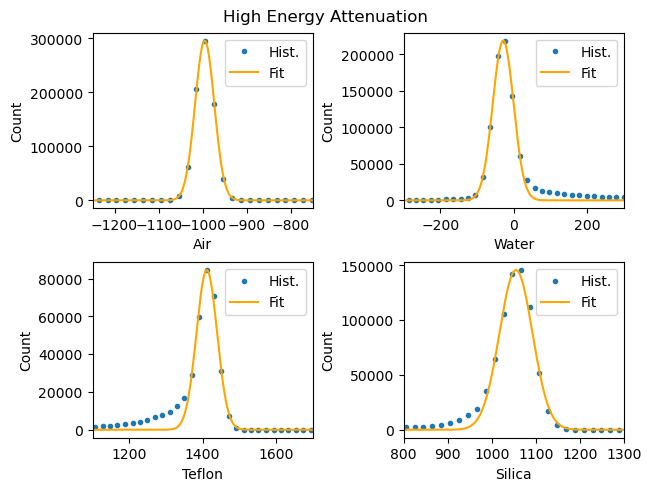

In [191]:
def gaussian(x, A, mu, sigma):
    return A*np.exp(-0.5*((x-mu)/sigma)**2)

fig1, ax1 = plt.subplots(2, 2, layout='constrained')
fig2, ax2 = plt.subplots(2, 2, layout='constrained')
fig1.suptitle('Low Energy Attenuation')
fig2.suptitle('High Energy Attenuation')

for hist, ax, mode in zip((dectgroup.lowEhistogram, dectgroup.highEhistogram),
                          (ax1, ax2),
                          ('low', 'high')):

    for k, (i, j, xlb) in enumerate(zip((0, 0, 1, 1),
                                        (0, 1, 0, 1),
                                        ('Air', 'Water', 'Teflon', 'Silica'))):
        ax[i][j].plot(hist['bin_centers'], hist[str(k+1)], '.', label='Hist.')

        xlim = dectgroup.__getattribute__(f'calibration_material{k}')[f'{mode}E_gaussian_center_bounds']
        xlim[0] -= 200
        xlim[1] += 200

        x = np.linspace(*xlim, 500)
        y = gaussian(
            x,
            A=dectgroup.calibration_gaussian_coefficients[f'A_{mode}E'].iloc[k],
            mu=dectgroup.calibration_gaussian_coefficients[f'mu_{mode}E'].iloc[k],
            sigma=dectgroup.calibration_gaussian_coefficients[f'sigma_{mode}E'].iloc[k])

        ax[i][j].plot(x, y, color='orange', label='Fit')
        ax[i][j].set_xlim(*xlim)
        ax[i][j].set_xlabel(xlb)
        ax[i][j].set_ylabel('Count')
        ax[i][j].legend()


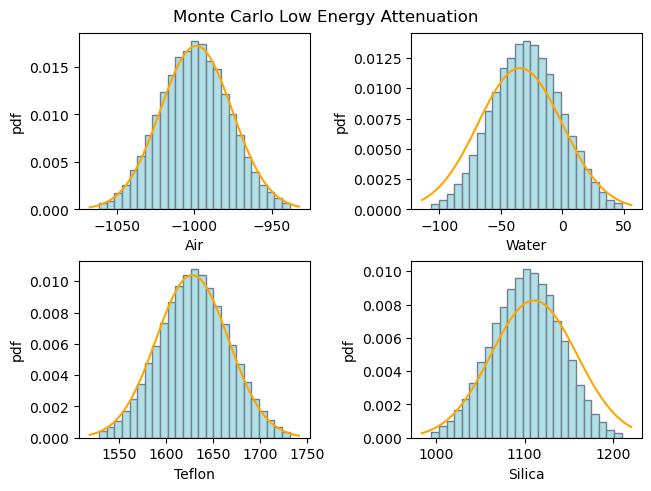

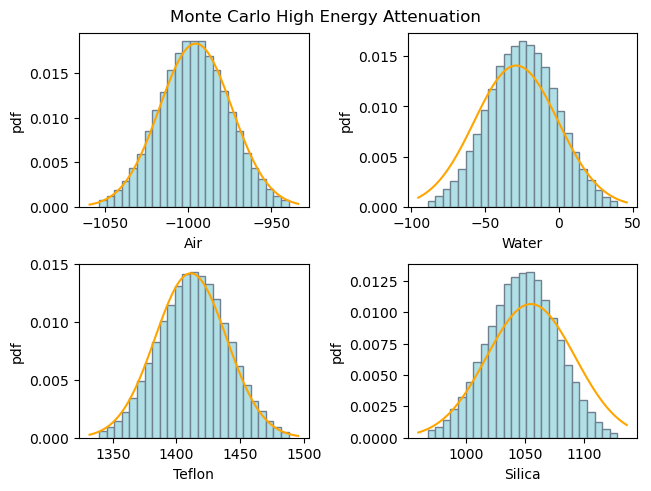

In [192]:
def gaussian_pdf(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-0.5*((x-mu)/sigma)**2)

fig1, ax1 = plt.subplots(2, 2, layout='constrained')
fig2, ax2 = plt.subplots(2, 2, layout='constrained')
fig1.suptitle('Monte Carlo Low Energy Attenuation')
fig2.suptitle('Monte Carlo High Energy Attenuation')


for ax, coef, mode in zip((ax1, ax2),
                          (dectgroup.lowE_inversion_coefficients,
                           dectgroup.highE_inversion_coefficients),
                           ('low', 'high')):
    for k, (i, j, xlb) in enumerate(zip((0, 0, 1, 1),
                                        (0, 1, 0, 1),
                                        ('Air', 'Water', 'Teflon', 'Silica'))):
        ax[i][j].hist(coef[f'CT_{k}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')

        ax[i][j].set_xlabel(xlb)
        ax[i][j].set_ylabel('pdf')
        x = np.linspace(*ax[i][j].get_xlim(), 100)
        mu = dectgroup.calibration_gaussian_coefficients[f'mu_{mode}E'].iloc[k],
        sigma = dectgroup.calibration_gaussian_coefficients[f'sigma_{mode}E'].iloc[k]
        y = gaussian_pdf(x, mu, sigma)
        ax[i][j].plot(x, y, color='orange', label='pdf')


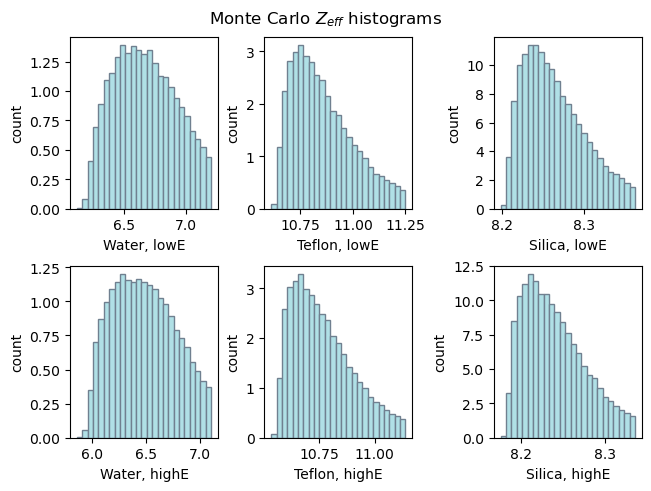

In [193]:
fig1, axs = plt.subplots(2, 3, layout='constrained')
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo $Z_{eff}$ histograms')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('Water', 'Teflon', 'Silica')):
        ax[k].hist(coef[f'Z_{k+1}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')
        ax[k].set_xlabel(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')


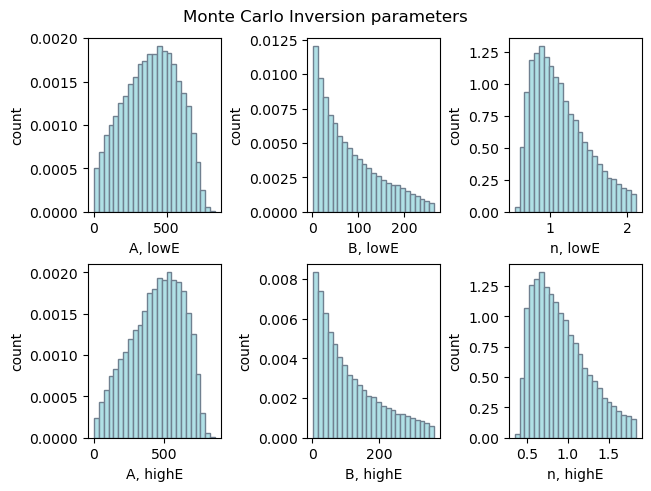

In [194]:
fig1, axs = plt.subplots(2, 3, layout='constrained')
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo Inversion parameters')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('A', 'B', 'n')):
        ax[k].hist(coef[f'{xlb}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')
        ax[k].set_xlabel(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')

## Run the Monte Carlo inversion

Once we are satisfied with these inversion parameters, we are ready to run the full inversion. 
For this, we only need to execute the following code snippet in a parallel environment:

```python
import rockverse as rv
dectgroup = rv.open(r'/path/to/dual_energy_ct/C04B21')
dectgroup.run()
```

Remember: we are utilizing Monte Carlo in the Digital Rock universe! This process is
computationally intensive and is meant to be run in a high-performance computing environment,
such as a GPU-enabled machine or a handful of nodes in a CPU cluster. If you just want to test
the inversion, you can go back to the mask definition and reduce the cylinder length to
allow the code to work only on a tiny part of the whole image.

After completion, you will have access to the Monte Carlo results through the
following new voxel images as attributes of dectgroup:

- ``rho_min``: Voxel image with the minimum electron density per voxel.
- ``rho_p25``: Voxel image with the the first quartile for the electron density per voxel.
- ``rho_p50``: Voxel image with the the median values for the electron density per voxel.
- ``rho_p75``: Voxel image with the the third quartile for the electron density per voxel.
- ``rho_max``: Voxel image with the maximum electron density per voxel.
- ``Z_min``: Voxel image with the minimum effective atomic number per voxel.
- ``Z_p25``: Voxel image with the the first quartile for the effective atomic number per voxel.
- ``Z_p50``: Voxel image with the the median values for the effective atomic number per voxel.
- ``Z_p75``: Voxel image with the the third quartile for the effective atomic number per voxel.
- ``Z_max``: Voxel image with the maximum effective atomic number per voxel.
- ``valid``: Voxel image with the number of valid Monte Carlo results for each voxel.